# Sber Futures Price Forecast

# Imports

In [376]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import lognorm, kstest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

from matplotlib.ticker import IndexLocator, FixedLocator

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import numpy as np
import pmdarima as pm

In [377]:
df = pd.read_csv('/Users/egorbykov/Desktop/Универ/Технический анализ и статистика фондового рынка/Курсовая/Sber_Price.csv', names=['date', 'values'], header=0, delimiter=';', index_col=False)

# Data observation

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    409 non-null    object
 1   values  409 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ KB


In [379]:
df.describe()

,values
count,409.000000
mean,18396.374083
std,8481.387356
min,10499.000000
25%,12649.000000
50%,13417.000000
75%,25993.000000
max,37695.000000


# Data preprocessing

## Modification of object type to date type

In [380]:
df.date = pd.to_datetime(df['date'], format='%d.%m.%Y').dt.strftime("%d-%m-%Y")

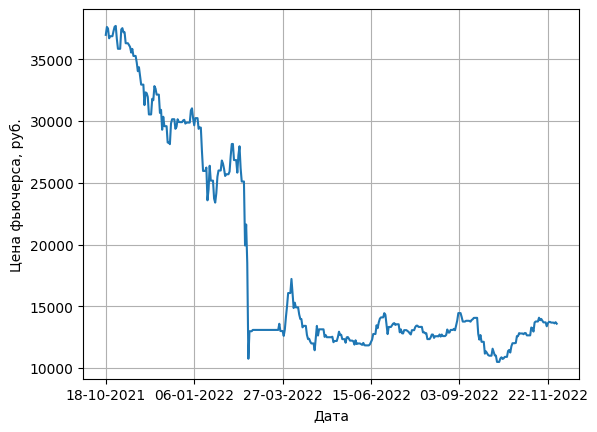

In [381]:
f = plt.figure()
ax1 = f.add_subplot()
ax1.plot(df['date'], df['values'])
ax1.xaxis.set_major_locator(IndexLocator(base=80, offset=0))
ax1.set_xlabel('Дата')
ax1.set_ylabel('Цена фьючерса, руб.')
ax1.grid()

We can see a structure change, which happened in February of 2022. Also trades were not held in March of 2022, so we will exclude them. To continue modeling we need to divide the time series for the one before the change and the one after the change



In [382]:
df_before_change = df[:126]
df_before_change

,date,values
0,18-10-2021,36969
1,19-10-2021,37612
2,20-10-2021,37484
3,21-10-2021,36692
4,22-10-2021,36862
...,...,...
121,16-02-2022,27954
122,17-02-2022,26184
123,18-02-2022,25103
124,19-02-2022,25103


In [383]:
df_after_change = df.tail(252)
df_after_change.head()

,date,values
157,24-03-2022,13587
158,25-03-2022,13000
159,26-03-2022,13000
160,27-03-2022,13000
161,28-03-2022,12603


# Modeling of the Sber futures price before the structure change

## Kolmogorov-Smirnov normality test

In [385]:
print(f"before structure change: {kstest(df_before_change['values'], 'norm')}")

before structure change: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=23393, statistic_sign=-1)


p-value < 0,05 -> distribution is not normal

## ADF Stationarity Test

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure

In [386]:
def acf_test(vector):
    result = adfuller(vector)
    print('ADF Statistics: %f' % result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, values in result[4].items():
        print('\t%s: %3f' % (key, values))

In [387]:
acf_test(df_before_change['values'])

ADF Statistics: -1.213683
p-value:  0.667682186298003
Critical Values:
	1%: -3.483779
	5%: -2.884954
	10%: -2.579257


p-value is much more than 0.05 -> data is not stationary.
We'll need to transofrm the data

Let's take the first difference and test the new data for stationarity

In [388]:
first_diff = df_before_change['values'].diff().dropna()

In [389]:
acf_test(first_diff)

ADF Statistics: -9.300283
p-value:  1.1172843969090855e-15
Critical Values:
	1%: -3.484667
	5%: -2.885340
	10%: -2.579463


Now the data is stationary

Plotting acf and pacf graphs

/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


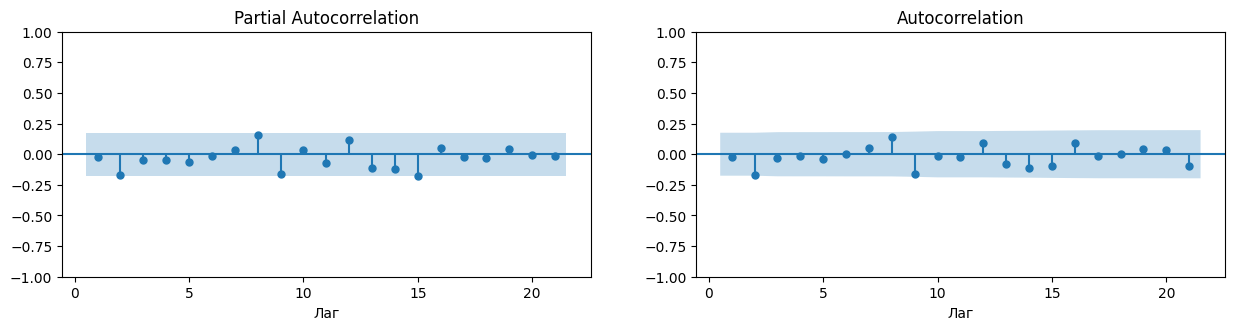

In [390]:
def acf_pacf(vector):
    f = plt.figure(figsize=(15, 7))
    ax1 = f.add_subplot(221)
    plot_pacf(vector, ax=ax1, zero=False)
    ax1.set_xlabel('Лаг')

    ax2 = f.add_subplot(222)
    plot_acf(vector, ax=ax2, zero=False)
    ax2.set_xlabel('Лаг')
    plt.show()
    
    
acf_pacf(first_diff)

Remains after taking the first difference are white noise. So the initial data is a random walking. 
Such processes are hard to predict and the best prediction would be the last value

We can compare our results of the order of ARIMA model with the results of auto_arima function

In [391]:
arima_before_change = pm.auto_arima(df_before_change['values'])
arima_before_change.summary()

/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1005.529
Date:                Mon, 13 Feb 2023   AIC                           2013.058
Time:                        00:23:18   BIC                           2015.887
Sample:                             0   HQIC                          2014.207
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.654e+05   5.61e+04     10.077      0.000    4.55e+05    6.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 8.19
Prob(Q):                              0.77   Prob(JB):                         0.02
Heteroskedasticity (H):               2.31   Skew:                            -0.30
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Creating an ARIMA plotting function

In [392]:
def create_ARIMA(vector, p, d, q):
    arima_model = ARIMA(vector['values'], order=(p, d, q))
    model = arima_model.fit()
    print(model.summary())

    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121)
    plot_predict(model, dynamic=False, ax=ax1, start=3, end=len(vector['values'])+5)
    vector.plot(label='цена фьючерса', ax=ax1)
    ax1.legend()
    fc = model.forecast(5)
    conf = model.get_forecast(5).conf_int(alpha=0.05)
    g = pd.DataFrame(conf)
    g['predicted'] = fc
    g = g[['lower values', 'predicted', 'upper values']]
    print(g)
    


                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  126
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1005.529
Date:                Mon, 13 Feb 2023   AIC                           2013.058
Time:                        00:23:18   BIC                           2015.887
Sample:                             0   HQIC                          2014.207
                                - 126                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.654e+05   5.61e+04     10.077      0.000    4.55e+05    6.75e+05
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 8.19
Prob(Q):                              0.77   Pr

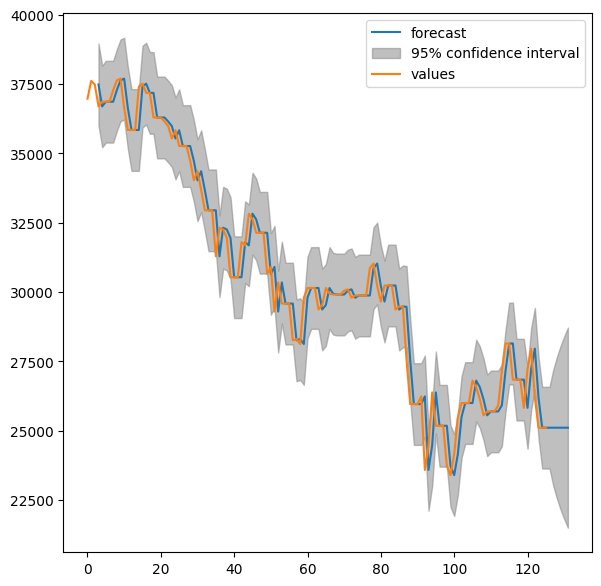

In [393]:
create_ARIMA(df_before_change, 0, 1, 0)

# Modeling of the Sber futures price after the structure change

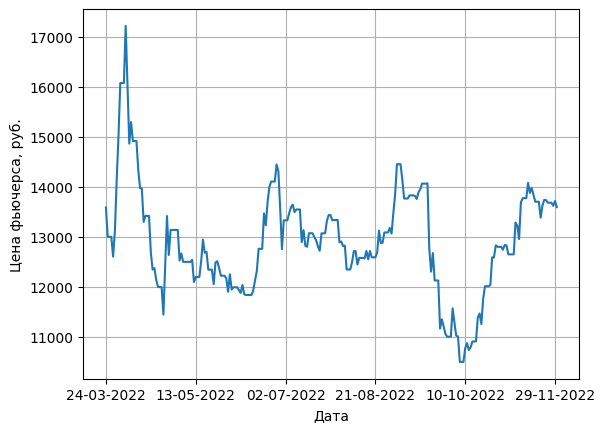

In [394]:
f = plt.figure()
ax1 = f.add_subplot()
ax1.plot(df_after_change['date'], df_after_change['values'])
ax1.xaxis.set_major_locator(IndexLocator(base=50, offset=0))
ax1.set_xlabel('Дата')
ax1.set_ylabel('Цена фьючерса, руб.')
ax1.grid()
#df.plot()
#plt.show()

## Kolmogorov-Smirnov normality test

In [396]:
print(f"after structure change: {kstest(df_after_change['values'], 'norm')}")

after structure change: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=10499, statistic_sign=-1)


p-value < 0,05 -> distribution is not normal

## ADF Stationarity Test

In [397]:
def acf_test(vector):
    result = adfuller(vector)
    print('ADF Statistics: %f' % result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, values in result[4].items():
        print('\t%s: %3f' % (key, values))

In [398]:
acf_test(df_after_change['values'])

ADF Statistics: -3.261791
p-value:  0.016675248183816056
Critical Values:
	1%: -3.456996
	5%: -2.873266
	10%: -2.573019


p-value < 0,05 -> data is stationary

Creating Partial Autocorrelation and Autocorrelation graphs

/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


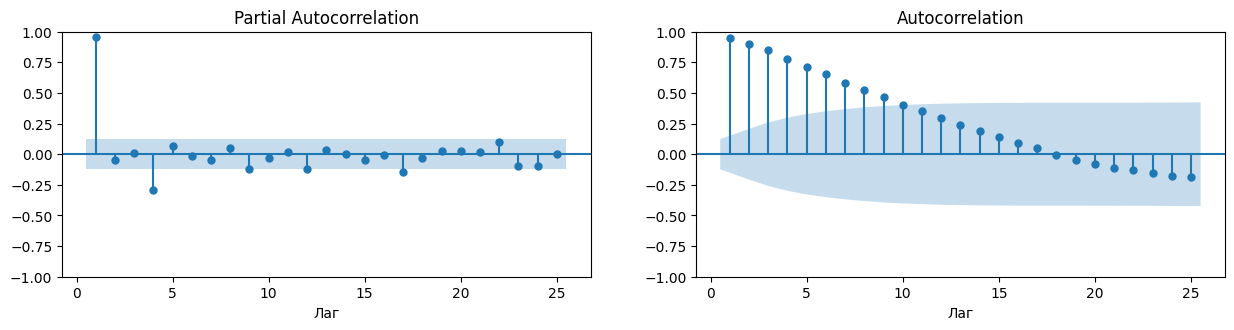

In [399]:
acf_pacf(df_after_change['values'])

According to the pacf and acf, the best fit model is ARIMA(1, 0, 0), 
because acf is decreasing exponentially
and
there is one first significant coefficient in pacf

Let's check the conclusion out with the auto_arima

In [400]:
arima_after_change = pm.auto_arima(df_after_change['values'])
arima_after_change.summary()

/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/egorbykov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  ret

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1815.107
Date:                Mon, 13 Feb 2023   AIC                           3636.214
Time:                        00:23:19   BIC                           3646.802
Sample:                             0   HQIC                          3640.475
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    633.7105    182.484      3.473      0.001     276.048     991.373
ar.L1          0.9512      0.013     70.756      0.000       0.925       0.978
sigma2      1.049e+05   5734.045     18.297      0.000    9.37e+04    1.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               120.23
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Indeed, ARIMA(1, 0, 0) is the best fit

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  252
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1815.127
Date:                Mon, 13 Feb 2023   AIC                           3636.254
Time:                        00:23:19   BIC                           3646.843
Sample:                             0   HQIC                          3640.515
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.29e+04    416.481     30.984      0.000    1.21e+04    1.37e+04
ar.L1          0.9489      0.013     70.526      0.000       0.922       0.975
sigma2      1.049e+05   5733.846     18.297      0.0

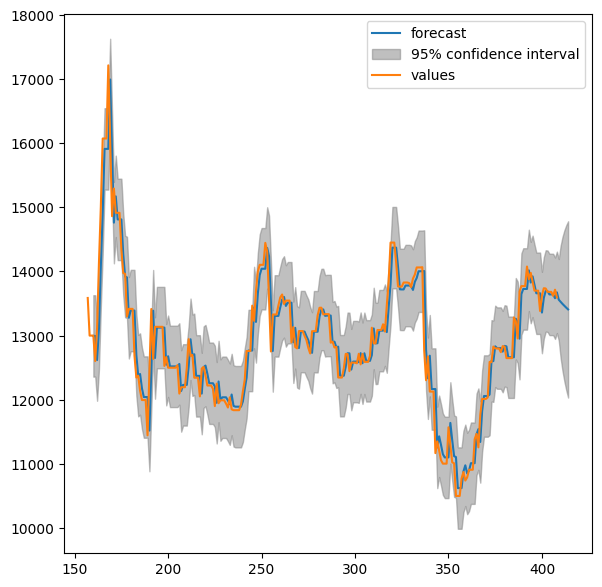

In [401]:
create_ARIMA(df_after_change, 1, 0, 0)

We can see that the price most likely will decrease